In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/elsevier/Bert-NER'
%cd $path
import utils_train as ut
import utils_annotate
import random
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import net
from trainer import train
from transformers import BertForMaskedLM, BertTokenizer
!pip install highlight-text
import matplotlib.pyplot as plt
from highlight_text import HighlightText

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/elsevier/Bert-NER


In [2]:
CLASSES = {'MATERIAL': 1,
           'MLIP': 2,
           'PROPERTY': 3,
           'SIMULATION': 4,
           'VALUE': 5,
           'APPL': 6,
           'O': 0}
N_DATA = 0  # 0 is all
N_TEST = 3
BATCH_SIZE = 1
SEED = 1
MAX_LENGTH = 512
CLASS_WEIGHTS = [0.3, 1., 1., 0.5, 1., 1., 1.]
LEARNING_RATE = 0.0001
N_EPOCHS = 2

In [3]:
ut.seed_everything(SEED)

In [4]:
tokenizerBERT = BertTokenizer.from_pretrained('pranav-s/MaterialsBERT', model_max_length=MAX_LENGTH)
modelBERT = BertForMaskedLM.from_pretrained('pranav-s/MaterialsBERT')
model = net.NERBERTModel(modelBERT.base_model, output_size=len(CLASSES)+1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
data = utils_annotate.combine_records('individual_ner')
utils_annotate.json_train_test('train_test_data', data, N_TEST, shuffle=True)
print(f'Number of training data: {len(data) - N_TEST}')
print(f'Number of test data: {N_TEST}')

Number of training data: 56
Number of test data: 3


Epoch 1
Mean training loss: 0.6268
Mean training accuracy: 0.8485
Test accuracy: 0.8694


Epoch 2
Mean training loss: 0.1790
Mean training accuracy: 0.9512
Test accuracy: 0.8674




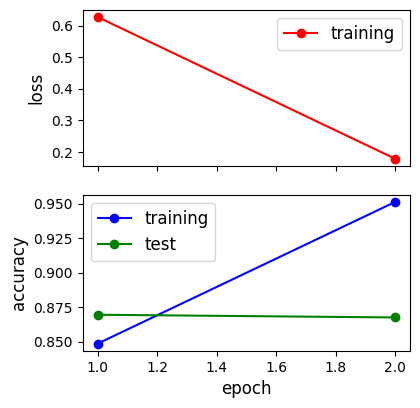

In [6]:
model, train_losses, train_accuracies, test_accuracies, pred_classes, true_classes, pred_all, true_all, data_list = train(model, tokenizerBERT,
   'train_test_data/data_train.json', 'train_test_data/data_test.json', CLASSES, N_DATA, BATCH_SIZE, SEED, MAX_LENGTH, CLASS_WEIGHTS, LEARNING_RATE, N_EPOCHS, plot=True, save_model=True)

# Show prediction

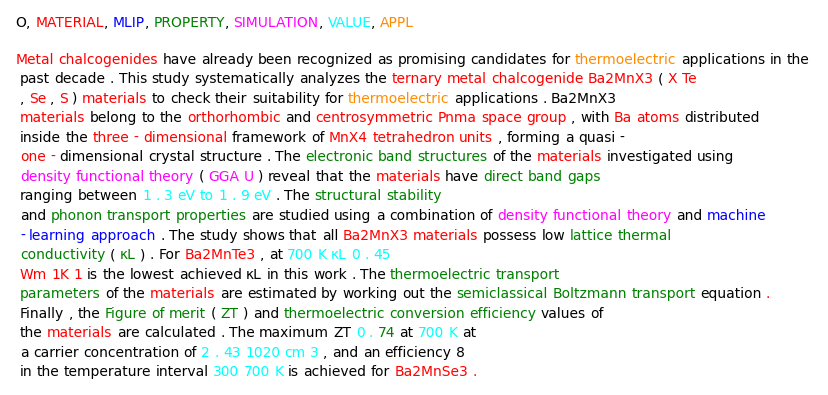

In [7]:
sample_id = 2
word_list = data_list[sample_id]['words']
labels = true_all
predictions = pred_all[sample_id, :, :].max(dim=0)[1]
colors = ['black', 'red', 'blue', 'green', 'magenta', 'cyan', 'darkorange']
real_preds = predictions[:len(word_list)]
word_list_marked = ['<' + w + '>' for w in word_list]
markers = [{"color": colors[i]} for i in real_preds]
j = 0
for i in range(len(word_list)):
    if (i + 1) % 15 == 0:
        word_list_marked.insert(i + j, '\n')
        j += 1
fig, ax = plt.subplots()
ax.set_axis_off()
HighlightText(x=0., y=1, s='<O>, <MATERIAL>, <MLIP>, <PROPERTY>, <SIMULATION>, <VALUE>, <APPL>',
              highlight_textprops=[{"color": c} for c in colors], ax=ax)
HighlightText(x=0., y=0.9, s=' '.join(word_list_marked),
              highlight_textprops=markers, ax=ax)
plt.show()

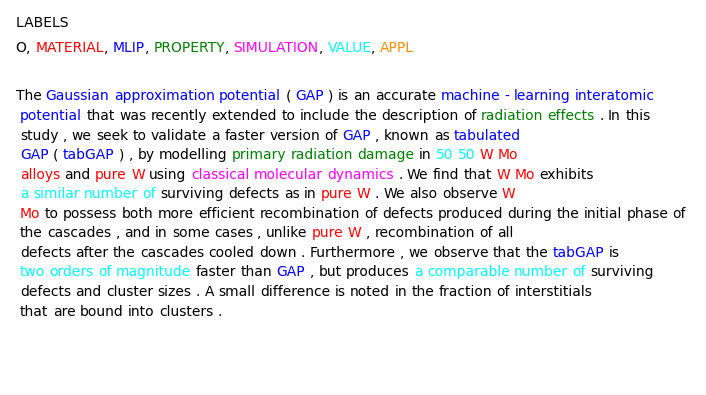

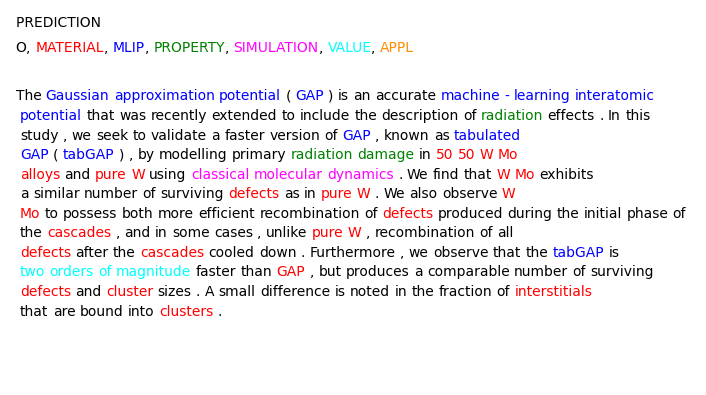

In [19]:
# Load and visualize previous test data
sample_file = 'saved_models/2024-04-09_n_0_b_1_s_1_l_512_w_[0.3, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0]_l_0.0001/2024-04-09_n_0_b_1_s_1_l_512_w_[0.3, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0]_l_0.0001_e_2_test_0.json'
with open(sample_file) as f:
    for jsonObj in f:
        record = json.loads(jsonObj)
colors = ['black', 'red', 'blue', 'green', 'magenta', 'cyan', 'darkorange']
word_list_marked = ['<' + w + '>' for w in record['words']]
markers_labels = [{"color": colors[i]} for i in record['labels']]
markers_pred = [{"color": colors[i]} for i in record['pred']]
j = 0
for i in range(len(record['words'])):
    if (i + 1) % 15 == 0:
        word_list_marked.insert(i + j, '\n')
        j += 1

fig, ax = plt.subplots()
ax.set_axis_off()
HighlightText(x=0., y=1, s='LABELS \n\n<O>, <MATERIAL>, <MLIP>, <PROPERTY>, <SIMULATION>, <VALUE>, <APPL>',
              highlight_textprops=[{"color": c} for c in colors], ax=ax)
HighlightText(x=0., y=0.8, s=' '.join(word_list_marked),
              highlight_textprops=markers_labels, ax=ax)
plt.show()

fig, ax = plt.subplots()
ax.set_axis_off()
HighlightText(x=0., y=1, s='PREDICTION \n\n<O>, <MATERIAL>, <MLIP>, <PROPERTY>, <SIMULATION>, <VALUE>, <APPL>',
              highlight_textprops=[{"color": c} for c in colors], ax=ax)
HighlightText(x=0., y=0.8, s=' '.join(word_list_marked),
              highlight_textprops=markers_pred, ax=ax)
plt.show()

In [8]:
# with open('test.txt', 'w+') as f:
#     for item in data_list[sample_id]['words']:
#         f.write(f'{item}\n')
# words_test = data_list[sample_id]['words']
# labels_test = labels[sample_id][:len(words_test)].tolist()
# pred_test = pred_all[sample_id, :, :].max(dim=0)[1][:len(words_test)].tolist()

In [9]:
# data_test_dict = {'words': words_test, 'labels': labels_test, 'pred': pred_test}
# with open(f'test.json', 'w') as f:
#     json.dump(data_test_dict, f)

In [10]:
# for i in range(N_TEST):
#     print(data_list[sample_id]['words'])
#     print(labels[sample_id])
#     print(pred_all[sample_id, :, :].max(dim=0)[1])